In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import matplotlib.pyplot as plt
import seaborn as sns
import re, nltk, os, json
from flask import jsonify
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sarcasmcleandata/SarcasmCleanData.csv


In [2]:
df = pd.read_csv("../input/sarcasmcleandata/SarcasmCleanData.csv")
df.head()

,Comments,Label
0,আমি মনে করি যখন মেয়েরা উদ্দেশ্য অনুসারে বোবা ...,1
1,আমি যখন কোনও গুরুত্বপূর্ণ প্রশ্ন জিজ্ঞাসা করি ...,1
2,বাহ ... আমি দেখতে দেখতে পাচ্ছি সত্যিই দোষী দোষ...,1
3,"হাহ, মজার বিষয়।#আনোয়েড #গ্রুআপ",1
4,থান্ডার আমাকে 830 এ জেগে উঠলে এটি ভালবাসুন,1


In [3]:
vocab_size = 10000 # max_features 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.Comments)
train_inputs = tokenizer.texts_to_sequences(df.Comments)

In [4]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=20)
train_labels = df['Label']
score = []
# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)
train_inputs[0]

array([   1,   32,   25,   38, 2439, 1167, 2440, 1584, 1584,  760,   70,
         14,   14,   45,   45,   40,    0,    0,    0,    0], dtype=int32)

In [52]:
def cleaned_reviews(review):
    """
    This function will remove the unncessary 
    symbols from a review such as punctuation mark, numbers ,emoji. 
    
    Args:
        review: str
        
    Returns:
        cleaned review: str
    """
    review = review.replace('\n', '') #removing new line 
    review = re.sub('[^\u0980-\u09FF]',' ',str(review)) #removing unnecessary punctuation
    return review
                                                 #=========================== 
                                                 ####### Function 2 #########
                                                 #===========================  
def stopwords_info(filename):
    """
    This function will create a stopwords list from the (.txt) file. 
    
    Args:
        filename: str
        
    Returns:
        stp: list of stopwords
        num_of_words: int
    """
    stp = open(filename,'r',encoding='utf-8').read().split()
    num_of_stopwords = len(stp)
    return stp,num_of_stopwords

                                                 #=========================== 
                                                 ####### Function 3 #########
                                                 #===========================  
def stopword_removal(review,stopwords):
    """
    This function will remove the stopwords from a review. 
    
    Args:
        review: str
        stopwords: str
        
    Returns:
        review without stopwords: str
    """
    stp,num_of_stopwords =stopwords_info(stopwords)
    result = review.split()
    reviews = [word.strip() for word in result if word not in stp ]
    reviews =" ".join(reviews)
    return reviews
                                                 #=========================== 
                                                 ####### Function 4 #########
                                                 #===========================               
def process_reviews(review,stopwords,removing_stopwords):
    """
    This function will process all the reviews which includes
    cleaning text and stopword removal.
    
    Args:
        review: str
        stopwords: filename
        removing_stopwords: boolean(True or False) 
        
    Returns:
        cleaned reviews: str
    """
    if removing_stopwords ==False:
        reviews = cleaned_reviews(review)
        
    else:
        reviews = cleaned_reviews(review)
        reviews = stopword_removal(reviews,stopwords)
        
    return reviews    



                                                 #=========================== 
                                                 ####### Function 5 #########
                                                 #===========================  

def data_summary(dataset):
    
    """
    This function will print the summary of the reviews and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    class_label= [k for k,v in dataset.Comments.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Label==label].Comments) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
    # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Documents per class
        documents.append(len(list(dataset[dataset.Label==label].Comments)))
    # Total Word per class
        words.append(len(word_list))
    # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].Comments))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
   
    return documents,words,u_words,class_label


                                       #==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================
def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels  


                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector . 
    
    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array) 
        
    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

                                            #======================================
                                            ##### Unigram Tf-idf value calculation
                                            #======================================
            
def calc_unigram_tfidf(reviews):
    """
    This function will return the tf-idf value of the unigram features . 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(reviews)
    
    return tfidf,X

                                            #======================================
                                            ##### Bi-gram Tf-idf value calculation
                                            #======================================
            
def calc_bigram_tfidf(reviews):
    """
    This function will return the tf-idf value of the bigram features . 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Bigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(reviews)
    
    return tfidf,X

                                            #======================================
                                            ##### Tri-gram Tf-idf value calculation
                                            #======================================


def calc_trigram_tfidf(reviews):
    """
    This function will return the tf-idf value of the bigram features . 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Tri-gram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(reviews)
    
    return tfidf,X

                                    #=======================
                                    ##### Print Tf-idf value
                                    #=======================

def show_tfidf(tfidf_instance,samp_review): 
    """
    This function will print the tfidf value of a specific review . 
    
    Args:
        tfidf_instance: an object
        samp_review   : string
        
    Returns:
        tfidf value of gram feature 
    """
    print("Sample Review: ",samp_review)
    first_vector = tfidf_instance.transform([samp_review])
    df = pd.DataFrame(first_vector.T.todense(), index=tfidf_instance.get_feature_names(), columns=["tfidf"])
    a = df.sort_values(by=["tfidf"],ascending=False)
    print(a[0:len(samp_review.split())])
    
    
                                              #============================================
                                              #########  Classifiers for Unigram  #########
                                              #============================================
def ml_models_for_unigram_tfidf(): 
    """
    This function consists the models defination for Unigram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    
    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.15)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    #lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    sgd_model = SGDClassifier(loss ='log',penalty='l2', max_iter=5)
    #model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM','SGD']
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Kernel SVM','SGD']
    # Create list of models
    #ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model,sgd_model]
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,ksvm_model,sgd_model]
    return ml_models,model_names    

    
                                              #============================================
                                              #########  Classifiers for Bigram  #########
                                              #============================================
def ml_models_for_bigram_tfidf(): 
    """
    This function consists the models defination for Bigram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.008)
    knn_model = KNeighborsClassifier(n_neighbors=2, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.3, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    sgd_model = SGDClassifier(loss = 'log',penalty='l2', max_iter=5)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM','SGD']
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model,sgd_model]
    return ml_models,model_names    


                                              #============================================
                                              #########  Classifiers for Trigram  #########
                                              #============================================
def ml_models_for_trigram_tfidf(): 
    """
    This function consists the models defination for Tri-gram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    
    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.001)
    knn_model = KNeighborsClassifier(n_neighbors=2, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.3, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.0002, random_state = 0)
    sgd_model = SGDClassifier(loss = 'log',penalty='l2', max_iter=5)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM','SGD']
    #create a list of models
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,ksvm_model,sgd_model]
    return ml_models,model_names     
    
    
                                           #============================================
                                           ####### Model Evaluation Function ############
                                           #=============================================

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.
    
    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        
    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100 
    print("Model => {} Accuracy: {} Precision: {} Recall {} F1-Score {}".format(model, my_dict['Accuracy'], my_dict['Precision'], my_dict['Recall'], my_dict['F1 Score'] ))
    return my_dict  

                                        #========================================
                                        #### Model Performane into Dataframe #####
                                        #=========================================
            
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.
    
    Args:
        performance_dict: a dictionary of all the parameters for each models
        
    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['LR','DT','RF','MNB','KNN','RBF SVM','SGD'])
    return performance_df

                                        #============================
                                        #### Plotting ROC Curve #####
                                        #============================



def plot_roc_curve(gram_models,X_train,X_test,y_train,y_test,gram_name):
    
    """
    This function will plot the ROC curve for all classifiers
    
    Args:
        gram_models: a function of all the models defination for a gram feature
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        gram_name: gram feature name(str)
        
    
    """
    
    ml_models,model_names = gram_models 

    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for i,model in enumerate(ml_models):
        model = model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[::,1]

        fpr, tpr, _ = roc_curve(y_test, y_pred)

        auc = roc_auc_score(y_test, y_pred)

        result_table = result_table.append({'classifiers':model_names[i],
                                            'fpr':fpr, 
                                            'tpr':tpr, 
                                            'auc':auc}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)

    # plotting
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=12)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=12)

    plt.title(f'ROC Curve Analysis for {gram_name} features', fontweight='bold', fontsize=12)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()
    
    
                                        #=========================================
                                        #### Plotting Precision-Recall Curve #####
                                        #========================================    
    
    
    
def plot_PR_curve(gram_models,X_train,X_test,y_train,y_test,gram_name):
    """
    This function will plot the Precision Recall curve for all classifiers
    
    Args:
        gram_models: a function of all the models defination for a gram feature
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        gram_name: gram feature name(str)
        
    
    """
    
    ml_models,model_names = gram_models 
    # Define a result table as a DataFrame
    result_table = pd.DataFrame(columns=['classifiers', 'precision','recall','AP'])

    # Train the models and record the results
    for i,model in enumerate(ml_models):
        model = model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[::,1]

        precision, recall,_ = precision_recall_curve(y_test, y_pred)

        average_precision = average_precision_score(y_test, y_pred)

        result_table = result_table.append({'classifiers':model_names[i],
                                            'precision':precision, 
                                            'recall':recall, 
                                            'AP': average_precision}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)

    # Plotting

    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['recall'], 
                 result_table.loc[i]['precision'], 
                 label="{}, AP={:.3f}".format(i, result_table.loc[i]['AP']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Recall", fontsize=12)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("Precision", fontsize=12)

    plt.title(f'PR Curve Analysis for {gram_name} features', fontweight='bold', fontsize=12)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [53]:
data_summary(df)


Class Name :  আমি এখনই ব্যস্ত, আমি কি আপনাকে অন্য কোনও সময় উপেক্ষা করতে পারি?
Number of Documents:0
Number of Words:0
Number of Unique Words:0
Most Frequent Words:


Class Name :  আমি বলছি না আমি আপনাকে ঘৃণা করি, আমি যা বলছি তা হ'ল আপনি আক্ষরিক অর্থে আমার জীবনের সোমবার।
Number of Documents:0
Number of Words:0
Number of Unique Words:0
Most Frequent Words:


Class Name :  আমি দুঃখিত যখন আমি আপনাকে বোকা বলি তখন আমি আপনার অনুভূতিতে আঘাত পেয়েছি।আমি সত্যিই ভেবেছিলাম আপনি ইতিমধ্যে জানেন।
Number of Documents:0
Number of Words:0
Number of Unique Words:0
Most Frequent Words:


Class Name :  হালকা শব্দের চেয়ে দ্রুত ভ্রমণ করে।এই কারণেই কিছু লোক কথা না বলা পর্যন্ত উজ্জ্বল প্রদর্শিত হয়।
Number of Documents:0
Number of Words:0
Number of Unique Words:0
Most Frequent Words:


Class Name :  বোকামির বিরুদ্ধে সার্কাসম হ'ল দেহের প্রাকৃতিক প্রতিরক্ষা।
Number of Documents:0
Number of Words:0
Number of Unique Words:0
Most Frequent Words:


Class Name :  আমার হারানোর আগে আপনার ধৈর্য সন্ধান করুন।
Number of

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [16]:
## classifiers defination
ml_models,model_names = ml_models_for_unigram_tfidf() 

In [17]:
print(model_names)
print(ml_models)

['Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'KNN', 'Kernel SVM', 'SGD']
[LogisticRegression(random_state=123), DecisionTreeClassifier(criterion='entropy', random_state=0), RandomForestClassifier(criterion='entropy', random_state=0), MultinomialNB(alpha=0.15), KNeighborsClassifier(n_neighbors=3), SVC(C=1000, gamma=0.00015, probability=True, random_state=0), SGDClassifier(loss='log', max_iter=5)]


In [22]:
# call model accuracy function and save the metrices into a dictionary
accuracy = {f'{model_names[i]}':model_performace(model,X_train, X_val, y_train, y_val) for i,model in enumerate(ml_models)}

# Save the performance parameter into json file
with open('ml_performance_unigram.json', 'w') as f:
    json.dump(accuracy, f)

Model => LogisticRegression(random_state=123) Accuracy: 61.919999999999995 Precision: 54.39000000000001 Recall 15.7 F1-Score 24.36
Model => DecisionTreeClassifier(criterion='entropy', random_state=0) Accuracy: 80.61 Precision: 73.86 Recall 77.97 F1-Score 75.86
Model => RandomForestClassifier(criterion='entropy', random_state=0) Accuracy: 91.10000000000001 Precision: 89.82 Recall 87.09 F1-Score 88.42999999999999
Model => MultinomialNB(alpha=0.15) Accuracy: 64.29 Precision: 53.66 Recall 63.04 F1-Score 57.97
Model => KNeighborsClassifier(n_neighbors=3) Accuracy: 71.61 Precision: 64.67 Recall 60.25 F1-Score 62.39
Model => SVC(C=1000, gamma=0.00015, probability=True, random_state=0) Accuracy: 71.22 Precision: 99.06 Recall 26.58 F1-Score 41.92
Model => SGDClassifier(loss='log', max_iter=5) Accuracy: 60.040000000000006 Precision: 48.67 Recall 41.77 F1-Score 44.96


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [25]:
# Load the json file
accuracy = json.load(open('ml_performance_unigram.json'))
table = performance_table(accuracy)
table

,Accuracy,Precision,Recall,F1 Score
LR,61.92,54.39,15.70,24.36
DT,80.61,73.86,77.97,75.86
RF,91.10,89.82,87.09,88.43
MNB,64.29,53.66,63.04,57.97
KNN,71.61,64.67,60.25,62.39
RBF SVM,71.22,99.06,26.58,41.92
SGD,60.04,48.67,41.77,44.96


In [26]:
print(f"Highest Accuracy achieved by {table.Accuracy.idxmax(axis = 0)} at = {max(table.Accuracy)}")
print(f"Highest F1-Score achieved by {table['F1 Score'].idxmax(axis = 0)} at = {max(table['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table['Precision'].idxmax(axis = 0)} at = {max(table['Precision'] )}")
print(f"Highest Recall Score achieved by {table['Recall'].idxmax(axis = 0)} at = {max(table['Recall'] )}")

Highest Accuracy achieved by RF at = 91.10000000000001
Highest F1-Score achieved by RF at = 88.42999999999999
Highest Precision Score achieved by RBF SVM at = 99.06
Highest Recall Score achieved by RF at = 87.09


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


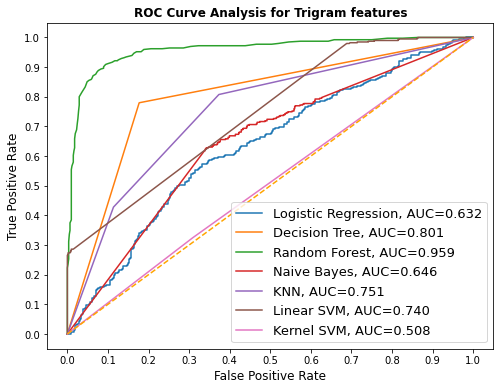

In [28]:

## classifiers defination
gram_models = ml_models_for_trigram_tfidf()

plot_roc_curve(gram_models,X_train,X_val,y_train,y_val,'Trigram')

#Precision Recall

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


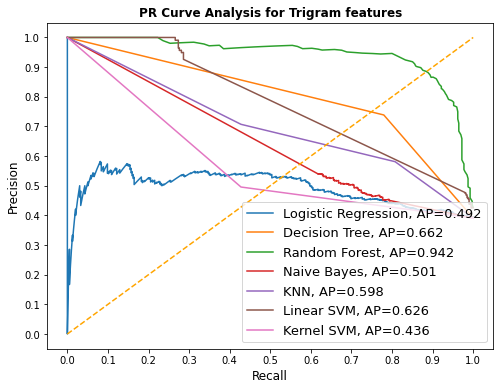

In [30]:

## classifiers defination
gram_models = ml_models_for_trigram_tfidf()

plot_PR_curve(gram_models,X_train,X_val,y_train,y_val,'Trigram')

In [37]:
from sklearn.naive_bayes import MultinomialNB


# calculate the Unigram Tf-idf feature
cv,feature_vector = calc_unigram_tfidf(df.Comments) 
# Encode the labels
lables = label_encoding(df.Label,False)
# Split the Feature into train and test set
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)

In [38]:
from sklearn.metrics import accuracy_score
mnb_model = MultinomialNB(alpha=0.15)
mnb_model.fit(X_train,y_train) 
y_pred = mnb_model.predict(X_test)
accuracy_score(y_true=y_test,y_pred=y_pred)*100

64.29277942631059

In [41]:
import pickle
# open a file, where you ant to store the data
file = open('NB.pkl', 'wb')

# dump information to that file
pickle.dump(mnb_model, file)